## SQL Injection Attacks Detection

We proceed to install the required packages and libraries.

In [3]:
import sys
!{sys.executable} -m pip install pandas matplotlib scikit-learn tensorflow


Defaulting to user installation because normal site-packages is not writeable


Import the required packages and libraries.

In [4]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import numpy as np

import requests
import tensorflow as tf

We proceed to load the dataset.

In [5]:
# Import data
train_df = pd.read_csv('./data/sql_train.csv')
valid_df = pd.read_csv('./data/sql_val.csv')
test_df = pd.read_csv('./data/sql_test.csv')

# Preprocessing
train_df['Sentence'] = train_df['Sentence'].apply(lambda x: str(x))
valid_df['Sentence'] = valid_df['Sentence'].apply(lambda x: str(x))
test_df['Sentence'] = test_df['Sentence'].apply(lambda x: str(x))

# Analyzing the dataset
We have 3 datasets: `train`, `validation` and `test`.
- `train` set has 45.288 entries
- `validation` set has 5.661 entries
- `test` set has 5.661 entries.

In [6]:
## Unique Characters
# Get a set of chars for Sentence in each set of data
char_set_train = train_df['Sentence'].apply(set)
char_set_val = valid_df['Sentence'].apply(set)
char_set_test = test_df['Sentence'].apply(set)

# Perform the union of all these sets to obtain the unique characters in each set
unique_chars_train = reduce(set.union, char_set_train)
unique_chars_val = reduce(set.union, char_set_val)
unique_chars_test = reduce(set.union, char_set_test)

# Getting the unique characters across the entire dataset that was provided
sets_list = [unique_chars_train, unique_chars_val, unique_chars_test]
unique_chars_overall = set().union(*sets_list)

# Sort them by their corresponding ascii value
unique_chars_train = sorted(unique_chars_train, key=ord)
unique_chars_val = sorted(unique_chars_val, key=ord)
unique_chars_test = sorted(unique_chars_test, key=ord)

unique_chars_overall = sorted(unique_chars_overall, key=ord)

# Printing the results
print(f"There are {len(unique_chars_train)} unique chars in training set.")
print(unique_chars_train)

print(f"There are {len(unique_chars_val)} unique chars in validation set.")
print(unique_chars_val)

print(f"There are {len(unique_chars_test)} unique chars in testing set.")
print(unique_chars_test)

print(f"There are {len(unique_chars_overall)} unique chars across all datasets.")
print(unique_chars_overall)

There are 127 unique chars in training set.
['\x18', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '~', '\x80', '\x98', '\xa0', '£', '½', 'Ã', 'ß', 'â', 'ä', 'ö', 'ü', '—', '‘', '’', '“', '”', '거', '길', '나', '난', '다', '동', '리', '멋', '빠', '요', '있', '주', '추', '트', '하', '홍']
There are 111 unique chars in validation set.
[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 

# Observations regarding characters
- The full English alphabet, in both lowercase and uppercase
- All the digits from 0 to 9
- Whitespace: ' '
- Mathematical operators: 
- Korean Characters: 거, 길, 나, 난, 다, 동, 리, 멋, 빠, 요, 있, 주, 추, 트, 하, 홍
- Characters from other latin alphabets: Ã, ß, â, ä, ö, ü
- Non-ASCII characters present encoding errors in CSV: \x18, \x80, \x98, \xa0
- Logical and Mathematical Operators
- Punctuation Marks
- Special irrelevant symbols: ½
- Currencies
- etc.

# Regarding datasets
The out-of-vocabulary characters that may be encountered by the soon-to-be ML model should be handled somehow: either they should be removed in preprocessing, or the model should be built in such a way that its performance isn't affected by these characters.

# Regarding SQL Syntax
## Case-Sensitivity - Converting to lowercase
The provided dataset is comprised of **SQL injection snippets**. We know for a fact that **SQL syntax is, for the most part, case-insensitive**. Keywords such as (SELECT, CREATE_TABLE) can be written in any way and still run fine. When it comes to table names, case-sensitivity **can** be enabled in certain DBMS's, but **I don't believe this will negatively impact the performance of the model**.

For the purposes of this challenge, and if my assumptions are correct, **converting the dataset to lowercase will not cause any significant context loss**.

# Using existing research

To compensate for my lack of experience (and truth be told, knowledge...) I've decided to look up research papers on this matter in order to gain some insights on the problem. I believe this doesn't break any of the rules of ths\ competition, as I'm only using these sources to better decide on how to approach the problem and come up with a decent-ish solution.

Disclaimer: The information that was extracted from the papers wasn't subjected to rigurous analysis due to lack of time and lack of experience in the field. I'm superficially scanning the sources and naively using the conclusions and results in my solution.

The papers which I've considered for the current problem are:
- https://scholarworks.sjsu.edu/cgi/viewcontent.cgi?article=1649&context=etd_projects
- https://revistageintec.net/wp-content/uploads/2022/02/1939.pdf

Relevant information that I've extracted from these papers:
- CNN's (Neural Networks in general) are more accurate, but they are costly in terms of resources and time
- Decision Tree algorithms (Ex: Random Forest) perform similarly to CNN's, but at a fraction of the resource costs
=> Conclusion: The Accuracy-Cost ratio of RF is better in comparison to CNN, and it also requires a significantly lower training and testing time than a Convolutional Neural Network. Therefore, I'm going to implement a decision forest model.

- The data needs to be processed appropriately: remove excess whitespaces, unknown characters and so on

Going further, a decision forest model is quite robust to overfitting. The validation data can still be used for tuning the model.

In [7]:
# Preprocessing the data

# Creating a list of all the characters that we want to keep
desired_alphabet = [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '~', '—', '‘', '’', '“', '”']

# Removing the characters that are not in the desired alphabet
train_df['Sentence'] = train_df['Sentence'].apply(lambda x: ''.join([char for char in x if char in desired_alphabet]))
valid_df['Sentence'] = valid_df['Sentence'].apply(lambda x: ''.join([char for char in x if char in desired_alphabet]))
test_df['Sentence'] = test_df['Sentence'].apply(lambda x: ''.join([char for char in x if char in desired_alphabet]))

# Creating a dictionary that maps each character to a unique integer
char_to_int = dict((c, i) for i, c in enumerate(desired_alphabet))

Plotting the length distribution of the queries in the dataset in order to determine the relevant length of the input sequences.

5364


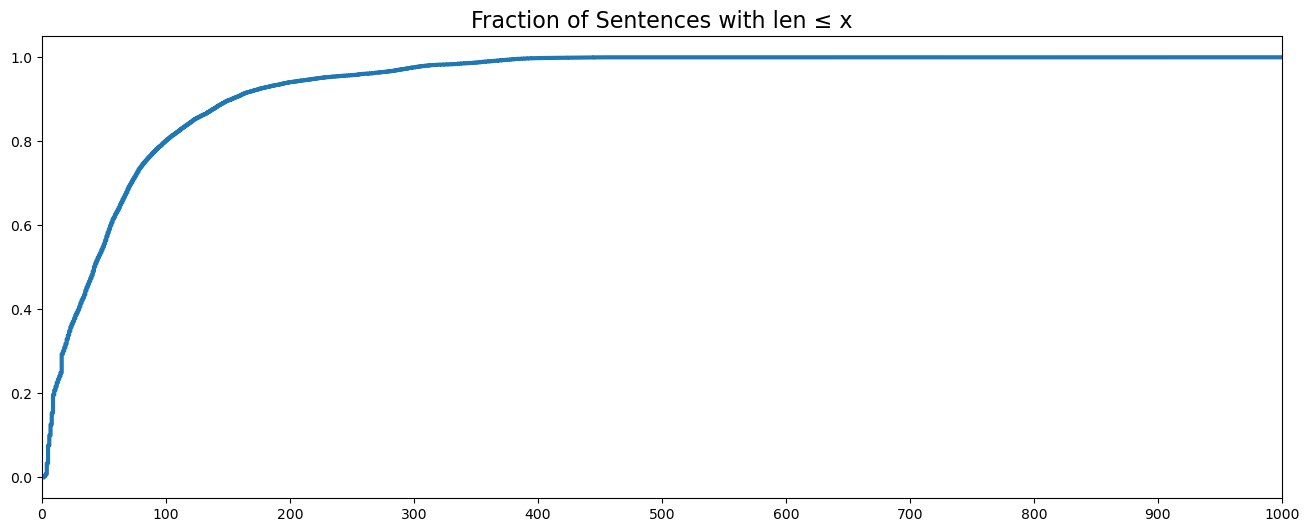

In [8]:
plt.figure(figsize=(16, 6))

x = np.sort(train_df['Sentence'].apply(len))
y = np.linspace(0, 1, len(x), endpoint=False)
plt.plot(x, y, lw=3)
plt.xticks(np.arange(0, x.max(), 100))
plt.xlim([0, 1000])

plt.title('Fraction of Sentences with len ≤ x', fontsize=16)
pass

print(max(train_df['Sentence'].apply(len)))


In [9]:
# Separating the data into X and y for each set
# X is the sentence and y is the label
X_train = train_df['Sentence']
y_train = train_df['Label']

X_valid = valid_df['Sentence']
y_valid = valid_df['Label']

X_test = test_df['Sentence']

In [10]:
# Tokenizing the data, all in the same way to avoid feature mismatch
# Creating a tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True, filters='')

# Fitting the tokenizer on the desired alphabet
tokenizer.fit_on_texts(desired_alphabet)

# Transforming the data into sequences of integers
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_test)

# Padding the sequences to make them all the same length
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=1000, padding='post')
X_valid = tf.keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=1000, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=1000, padding='post')

In [11]:
# Creating the model architecture
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)

In [12]:
# Fit the model
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   17.8s finished


RandomForestClassifier(random_state=42, verbose=1)

In [13]:
# Predict on the validation set
y_pred = rf_model.predict(X_valid)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [14]:
# Calculate the accuracy in percentage
accuracy = accuracy_score(y_valid, y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 99.43%


In [15]:
# Test a SQL injection and classify it as malicious or benign
test = "1' OR 1=1; --"
test = tokenizer.texts_to_sequences(test)
test = tf.keras.preprocessing.sequence.pad_sequences(test, maxlen=1000, padding='post')
test_pred = rf_model.predict(test)
test_pred_binary = [1 if x > 0.5 else 0 for x in test_pred]

if test_pred_binary[0] == 1:
    print("Malicious")
else:
    print("Benign")

Malicious


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
